In [33]:
# Cell 1: Imports
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import timm  # Pretrained models including EfficientNet
import glob


In [10]:
class UADFVFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label, class_name in enumerate(['real', 'fake']):
            class_path = os.path.join(root_dir, class_name, 'frames')
            video_folders = glob.glob(os.path.join(class_path, '*'))

            for folder in video_folders:
                for img_path in glob.glob(os.path.join(folder, '*.png')):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [11]:
class DFTIMITFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label, class_name in enumerate(['real', 'fake']):
            class_path = os.path.join(root_dir, class_name)
            video_folders = glob.glob(os.path.join(class_path, '*'))

            for folder in video_folders:
                for img_path in glob.glob(os.path.join(folder, '*.png')):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [41]:
import os
import cv2
import glob
from tqdm import tqdm

def extract_frames_from_videos(video_dir, output_dir, fps=1):
    os.makedirs(output_dir, exist_ok=True)
    video_files = glob.glob(os.path.join(video_dir, '*.mp4'))  # ✅ Correct usage

    for video_path in tqdm(video_files, desc="Extracting frames"):
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        frame_output_dir = os.path.join(output_dir, video_name)
        os.makedirs(frame_output_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(frame_rate // fps) if fps < frame_rate else 1

        frame_count = 0
        saved_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_interval == 0:
                out_path = os.path.join(frame_output_dir, f"{saved_count:04d}.png")
                cv2.imwrite(out_path, frame)
                saved_count += 1
            frame_count += 1
        cap.release()

In [30]:
# Example for Deepfakes/c40
extract_frames_from_videos(
    video_dir='E:/PythonProject/FaceForensics++/manipulated_sequences/Deepfakes/c40/videos',
    output_dir='E:/PythonProject/FaceForensics++/manipulated_sequences/Deepfakes/c40/frames',
    fps=1
)

# Similarly extract real/original videos
extract_frames_from_videos(
    video_dir='E:/PythonProject/FaceForensics++/original_sequences/youtube/c40/videos',
    output_dir='E:/PythonProject/FaceForensics++/original_sequences/youtube/c40/frames',
    fps=1
)


Extracting frames: 100%|██████████| 50/50 [02:16<00:00,  2.73s/it]


In [31]:
class FaceForensicsDataset(Dataset):
    def __init__(self, root_dir, method='Deepfakes', compression='c40', transform=None):
        self.samples = []
        self.transform = transform

        # Real frames
        real_path = os.path.join(root_dir, 'original_sequences', 'youtube', compression, 'frames')
        real_video_dirs = glob.glob(os.path.join(real_path, '*'))
        for folder in real_video_dirs:
            for img_path in glob.glob(os.path.join(folder, '*.png')):
                self.samples.append((img_path, 0))

        # Fake frames
        fake_path = os.path.join(root_dir, 'manipulated_sequences', method, compression, 'frames')
        fake_video_dirs = glob.glob(os.path.join(fake_path, '*'))
        for folder in fake_video_dirs:
            for img_path in glob.glob(os.path.join(folder, '*.png')):
                self.samples.append((img_path, 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [13]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [14]:

import torch.nn.functional as F
from torchvision.models import resnet18
from timm.models import create_model

class FFDModel(nn.Module):
    def __init__(self):
        super(FFDModel, self).__init__()
        self.backbone = create_model('xception', pretrained=True, num_classes=0, global_pool='')

        self.attention = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone.forward_features(x)  # [B, 2048, H, W]
        attention_map = self.attention(features)  # [B, 1, H, W]
        attended_features = features * attention_map
        out = self.fc(attended_features)
        return out, attention_map


In [15]:
def train_model(dataset, name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiAttentionModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss()

    dataset_size = len(dataset)
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = eval_transform
    test_dataset.dataset.transform = eval_transform

    train_loader = DataLoader(train_dataset, batch_size=75, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=75, shuffle=False)

    def train_epoch():
        model.train()
        total_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.float().to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        return total_loss / len(train_loader.dataset)

    for epoch in range(5):
        loss = train_epoch()
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}")

    os.makedirs(f"saved_models/{name}", exist_ok=True)
    torch.save(model.state_dict(), f"saved_models/{name}/model.pth")
    return model, test_loader


In [16]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU is not available. Using CPU.")

✅ GPU is available: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [17]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            preds = model(images)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    auc = roc_auc_score(all_labels, all_preds)
    print(f"Test AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'Test AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Set')
    plt.legend()
    plt.grid(True)
    plt.show()

In [36]:
data = UADFVFrameDataset("E:/PythonProject/UADFV")
model, test_loader = train_model(data, "UADFV")

E:\PythonProject\.venv\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(
100%|██████████| 25/25 [05:53<00:00, 14.13s/it]


Epoch 1: Loss = 0.5148


100%|██████████| 25/25 [05:39<00:00, 13.57s/it]


Epoch 2: Loss = 0.0638


100%|██████████| 25/25 [05:23<00:00, 12.95s/it]


Epoch 3: Loss = 0.0338


100%|██████████| 25/25 [05:40<00:00, 13.60s/it]


Epoch 4: Loss = 0.0245


100%|██████████| 25/25 [04:55<00:00, 11.83s/it]


Epoch 5: Loss = 0.0193


Test AUC: 0.9993


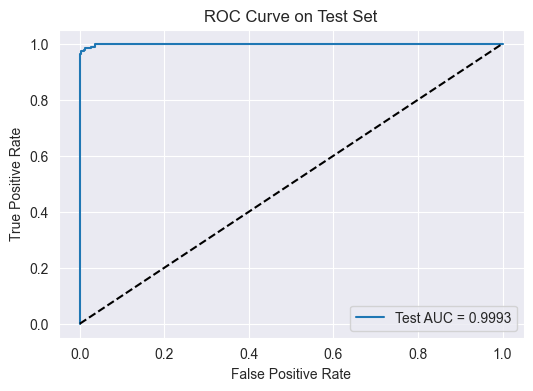

In [38]:
evaluate_model(model,test_loader)

In [34]:
data = FaceForensicsDataset(
    root_dir="E:/PythonProject/FaceForensics++",
    method='Deepfakes',
    compression='c40'
)
print("Loaded", len(data), "images")
model, test_loader = train_model(data, "FFPP_Deepfakes_c40")


Loaded 1752 images


100%|██████████| 15/15 [03:24<00:00, 13.64s/it]


Epoch 1: Loss = 0.6937


100%|██████████| 15/15 [03:04<00:00, 12.31s/it]


Epoch 2: Loss = 0.6806


100%|██████████| 15/15 [03:06<00:00, 12.44s/it]


Epoch 3: Loss = 0.5710


100%|██████████| 15/15 [03:03<00:00, 12.24s/it]


Epoch 4: Loss = 0.2939


100%|██████████| 15/15 [03:03<00:00, 12.25s/it]


Epoch 5: Loss = 0.1713


Test AUC: 0.9531


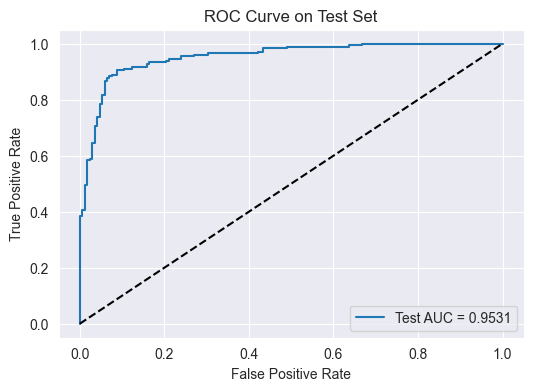

In [35]:
evaluate_model(model,test_loader)

In [42]:
extract_frames_from_videos(
    video_dir='E:/PythonProject/FaceForensics++/manipulated_sequences/Face2Face/c40/videos',
    output_dir='E:/PythonProject/FaceForensics++/manipulated_sequences/Face2Face/c40/frames',
    fps=1
)

Extracting frames: 100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


In [44]:
data = FaceForensicsDataset(
    root_dir="E:/PythonProject/FaceForensics++",
    method='Face2Face',
    compression='c40'
)
print("Loaded", len(data), "images")
model, test_loader = train_model(data, "FFPP_Face2Face_c40")

Loaded 1807 images


100%|██████████| 15/15 [03:28<00:00, 13.91s/it]


Epoch 1: Loss = 0.6891


100%|██████████| 15/15 [03:54<00:00, 15.64s/it]


Epoch 2: Loss = 0.6450


100%|██████████| 15/15 [04:34<00:00, 18.32s/it]


Epoch 3: Loss = 0.5675


100%|██████████| 15/15 [04:54<00:00, 19.64s/it]


Epoch 4: Loss = 0.4829


100%|██████████| 15/15 [03:29<00:00, 13.98s/it]


Epoch 5: Loss = 0.3916


Test AUC: 0.7165


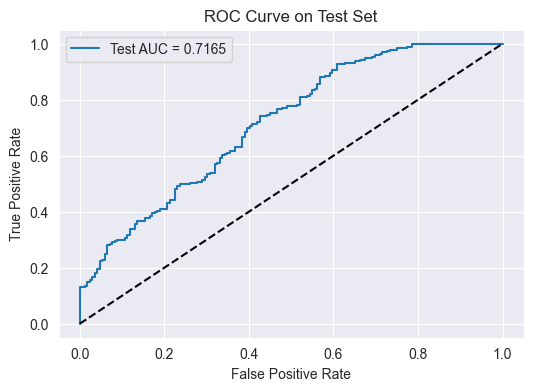

In [45]:
evaluate_model(model,test_loader)

In [46]:
extract_frames_from_videos(
    video_dir='E:/PythonProject/FaceForensics++/manipulated_sequences/FaceShifter/c40/videos',
    output_dir='E:/PythonProject/FaceForensics++/manipulated_sequences/FaceShifter/c40/frames',
    fps=1
)

Extracting frames: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


In [47]:
data = FaceForensicsDataset(
    root_dir="E:/PythonProject/FaceForensics++",
    method='FaceShifter',
    compression='c40'
)
print("Loaded", len(data), "images")
model, test_loader = train_model(data, "FFPP_FaceShifter_c40")

Loaded 1758 images


E:\PythonProject\.venv\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(
100%|██████████| 15/15 [03:18<00:00, 13.21s/it]


Epoch 1: Loss = 0.6951


100%|██████████| 15/15 [03:08<00:00, 12.55s/it]


Epoch 2: Loss = 0.6849


100%|██████████| 15/15 [03:08<00:00, 12.55s/it]


Epoch 3: Loss = 0.6545


100%|██████████| 15/15 [03:08<00:00, 12.54s/it]


Epoch 4: Loss = 0.5663


100%|██████████| 15/15 [03:08<00:00, 12.54s/it]


Epoch 5: Loss = 0.4241


Test AUC: 0.8845


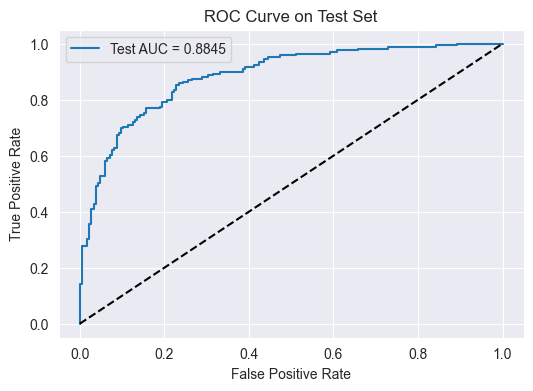

In [48]:
evaluate_model(model,test_loader)